<a href="https://colab.research.google.com/github/ZoulKuo/zhongyuan/blob/main/notebook/train_yolov12_shoplifting_object_detection_20250904_70epoch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Thu Sep  4 07:42:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [3]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 51.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 98.3 MB/s eta 0:00:00


### Download example data

Let's download an image we can use for YOLOv12 inference. Feel free to drag and drop your own images into the Files tab on the left-hand side of Google Colab, then reference their filenames in your code for a custom inference demo.

In [4]:
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

--2025-09-04 07:43:57--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg’

dog.jpeg            100%[===================>] 103.57K  --.-KB/s    in 0.001s  

2025-09-04 07:43:57 (111 MB/s) - ‘dog.jpeg’ saved [106055/106055]



## Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/yolov12/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
FlashAttention is not available on this device. Using scaled_dot_product_attention instead.


100%|██████████| 5.26M/5.26M [00:00<00:00, 92.7MB/s]


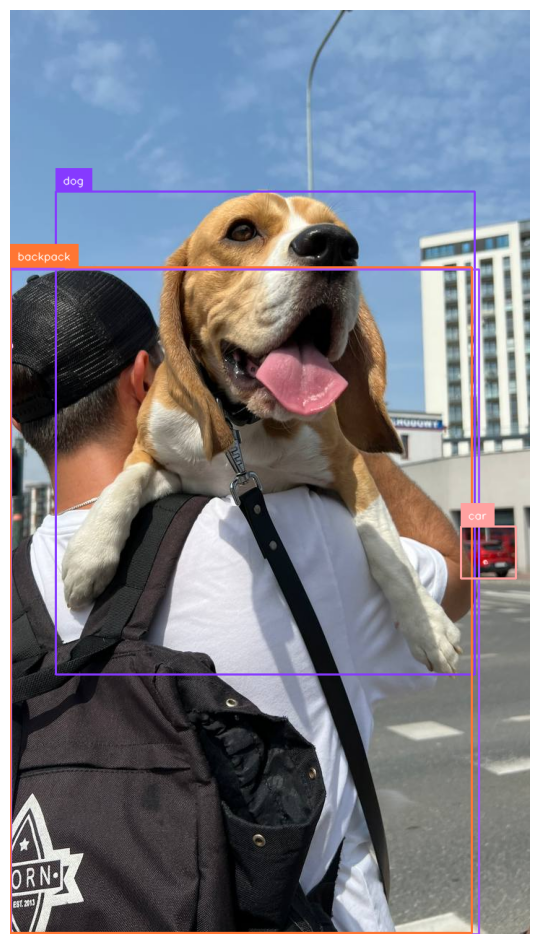

In [5]:
import cv2
from ultralytics import YOLO
import supervision as sv


image_path = f"{HOME}/dog.jpeg"
image = cv2.imread(image_path)

model = YOLO('yolov12n.pt')

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

## Download dataset from Roboflow Universe

In [6]:
!pip install roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="zaFOcSSyUyXqzWgj3MZV")
project = rf.workspace("fastnuces-uakqb").project("fyp-shoplift")
version = project.version(21)
dataset = version.download("yolov12")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to FYP-Shoplift-21 in yolov12:: 100%|██████████| 10110/10110 [00:01<00:00, 5551.82it/s]


In [7]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [8]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [9]:
!cat {dataset.location}/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 2
names: ['normal', 'shoplifting']

roboflow:
  workspace: fastnuces-uakqb
test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [10]:
from ultralytics import YOLO

model = YOLO('yolov12n.pt')

results = model.train(data=f'{dataset.location}/data.yaml', epochs=70)

New https://pypi.org/project/ultralytics/8.3.192 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12n.pt, data=/content/FYP-Shoplift-21/data.yaml, epochs=70, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, sa

100%|██████████| 755k/755k [00:00<00:00, 24.0MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      2368  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2, 1, 2]          
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1      9344  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2, 1, 4]          
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  2    174720  ultralytics.nn.modules.block.A2C2f           [128, 128, 2, True, 4]        
  7                  -1  1    295424  ultralytics

train: Scanning /content/FYP-Shoplift-21/train/labels... 3717 images, 100 backgrounds, 0 corrupt: 100%|██████████| 3717/3717 [00:01<00:00, 2194.39it/s]


train: New cache created: /content/FYP-Shoplift-21/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 1381, len(boxes) = 6538. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/FYP-Shoplift-21/valid/labels... 918 images, 18 backgrounds, 0 corrupt: 100%|██████████| 918/918 [00:00<00:00, 944.99it/s]

val: New cache created: /content/FYP-Shoplift-21/valid/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 588, len(boxes) = 1729. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 70 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/70       3.8G      1.487      2.104        1.4         16        640: 100%|██████████| 233/233 [01:57<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:29<00:00,  1.03s/it]

                   all        918       1729      0.443       0.63      0.451      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/70      3.81G      1.454       1.61      1.402         15        640: 100%|██████████| 233/233 [01:31<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  4.03it/s]

                   all        918       1729      0.512       0.54       0.51      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/70      3.81G      1.431      1.474      1.402         33        640: 100%|██████████| 233/233 [01:27<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.56it/s]

                   all        918       1729      0.539      0.528      0.452      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/70      3.79G        1.4      1.369      1.386         16        640: 100%|██████████| 233/233 [01:27<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.95it/s]

                   all        918       1729      0.458      0.548      0.446      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/70      3.79G      1.357       1.28       1.35         10        640: 100%|██████████| 233/233 [01:29<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.47it/s]

                   all        918       1729      0.514      0.667      0.573       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/70      3.77G      1.329      1.253      1.345         17        640: 100%|██████████| 233/233 [01:27<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  4.07it/s]

                   all        918       1729      0.468      0.698      0.539      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/70      3.79G       1.29      1.197      1.318         12        640: 100%|██████████| 233/233 [01:27<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.55it/s]

                   all        918       1729      0.525      0.736      0.624      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/70      3.78G      1.269      1.175      1.307         13        640: 100%|██████████| 233/233 [01:26<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.16it/s]

                   all        918       1729       0.58       0.71      0.602       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/70      3.79G      1.254      1.148      1.299         31        640: 100%|██████████| 233/233 [01:27<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.63it/s]

                   all        918       1729      0.519      0.766      0.639      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/70      3.79G      1.233      1.132      1.284         12        640: 100%|██████████| 233/233 [01:27<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  4.13it/s]

                   all        918       1729      0.584      0.731      0.646      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/70      3.77G      1.206      1.098      1.277         14        640: 100%|██████████| 233/233 [01:26<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.55it/s]

                   all        918       1729      0.568      0.633      0.636      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/70      3.76G      1.202      1.093      1.265         21        640: 100%|██████████| 233/233 [01:27<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.74it/s]

                   all        918       1729      0.554      0.746      0.668      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/70      3.79G      1.176      1.062      1.254         23        640: 100%|██████████| 233/233 [01:28<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.51it/s]

                   all        918       1729       0.62      0.706      0.667      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/70      3.79G      1.167      1.052       1.25         16        640: 100%|██████████| 233/233 [01:28<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  4.04it/s]

                   all        918       1729      0.561      0.829      0.703      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/70      3.79G      1.144      1.031       1.24         20        640: 100%|██████████| 233/233 [01:27<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.60it/s]

                   all        918       1729      0.621      0.785      0.708      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/70      3.79G      1.139       1.03      1.237         12        640: 100%|██████████| 233/233 [01:26<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.84it/s]

                   all        918       1729      0.626        0.8      0.717      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/70      3.79G      1.123      1.007      1.233         20        640: 100%|██████████| 233/233 [01:28<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.68it/s]

                   all        918       1729      0.586      0.853      0.729       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/70       3.8G      1.117      1.004      1.228         20        640: 100%|██████████| 233/233 [01:26<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.90it/s]

                   all        918       1729      0.645      0.766      0.714      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/70      3.79G      1.113     0.9945      1.221         11        640: 100%|██████████| 233/233 [01:26<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.66it/s]

                   all        918       1729      0.575      0.825      0.702       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/70       3.8G      1.095     0.9864      1.213         12        640: 100%|██████████| 233/233 [01:25<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.55it/s]

                   all        918       1729      0.617      0.804      0.731       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/70      3.78G      1.089     0.9831      1.212         13        640: 100%|██████████| 233/233 [01:26<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  4.01it/s]

                   all        918       1729      0.677      0.769      0.792      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/70      3.79G      1.082     0.9571      1.209         24        640: 100%|██████████| 233/233 [01:26<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.65it/s]

                   all        918       1729       0.66      0.783      0.786      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/70      3.79G      1.077     0.9389      1.207         15        640: 100%|██████████| 233/233 [01:27<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  4.02it/s]

                   all        918       1729      0.627      0.839      0.797      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/70      3.76G      1.057     0.9409      1.194         16        640: 100%|██████████| 233/233 [01:26<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.65it/s]

                   all        918       1729       0.71      0.747      0.775      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/70      3.77G      1.061     0.9359      1.198          9        640: 100%|██████████| 233/233 [01:25<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.69it/s]

                   all        918       1729      0.652      0.821      0.796      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/70      3.81G      1.044     0.9161      1.189         21        640: 100%|██████████| 233/233 [01:27<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.58it/s]

                   all        918       1729      0.663      0.773      0.785      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/70      3.79G       1.04     0.9222      1.183         13        640: 100%|██████████| 233/233 [01:26<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.59it/s]

                   all        918       1729      0.646      0.842      0.794      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/70      3.76G      1.034     0.9115      1.182         17        640: 100%|██████████| 233/233 [01:27<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.99it/s]

                   all        918       1729      0.638      0.834      0.796      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/70      3.79G      1.028     0.9141      1.181         24        640: 100%|██████████| 233/233 [01:26<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.61it/s]

                   all        918       1729      0.676      0.772      0.788      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/70      3.78G      1.021     0.9008      1.181         26        640: 100%|██████████| 233/233 [01:27<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.95it/s]

                   all        918       1729      0.648      0.861      0.794      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/70      3.79G      1.012     0.8887      1.172         17        640: 100%|██████████| 233/233 [01:27<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.56it/s]

                   all        918       1729      0.652      0.866      0.813      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/70      3.78G      1.012      0.885      1.172         22        640: 100%|██████████| 233/233 [01:27<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  4.08it/s]

                   all        918       1729      0.649      0.816      0.793      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/70      3.77G     0.9953     0.8919      1.164         26        640: 100%|██████████| 233/233 [01:27<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.52it/s]

                   all        918       1729      0.668      0.836      0.811      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/70      3.79G      1.002     0.8709      1.156         22        640: 100%|██████████| 233/233 [01:27<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  4.00it/s]

                   all        918       1729      0.628      0.916       0.82      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/70      3.79G     0.9898      0.861      1.158         10        640: 100%|██████████| 233/233 [01:26<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.59it/s]

                   all        918       1729      0.653      0.844      0.799      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/70      3.78G     0.9808     0.8675      1.156         20        640: 100%|██████████| 233/233 [01:28<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  4.04it/s]

                   all        918       1729      0.671      0.867      0.794      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/70      3.77G     0.9721     0.8615      1.148         11        640: 100%|██████████| 233/233 [01:26<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.59it/s]

                   all        918       1729      0.683      0.828      0.802      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/70      3.81G     0.9622     0.8483      1.148          9        640: 100%|██████████| 233/233 [01:27<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  4.08it/s]

                   all        918       1729      0.667       0.86      0.822      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/70      3.81G     0.9733     0.8583      1.155         24        640: 100%|██████████| 233/233 [01:28<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.65it/s]

                   all        918       1729      0.668      0.861      0.819      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/70      3.78G     0.9478     0.8324      1.138         15        640: 100%|██████████| 233/233 [01:28<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.83it/s]

                   all        918       1729      0.679      0.866      0.814      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/70      3.81G     0.9524     0.8274      1.145         23        640: 100%|██████████| 233/233 [01:28<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.57it/s]

                   all        918       1729      0.681      0.844      0.821      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/70      3.78G     0.9461     0.8304      1.137         18        640: 100%|██████████| 233/233 [01:26<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  4.02it/s]

                   all        918       1729       0.68      0.856      0.818      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/70      3.79G     0.9363     0.8217      1.136         15        640: 100%|██████████| 233/233 [01:27<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.63it/s]

                   all        918       1729      0.664      0.865      0.828      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/70      3.76G     0.9222     0.8124       1.12         16        640: 100%|██████████| 233/233 [01:28<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  4.06it/s]

                   all        918       1729      0.689      0.872      0.832      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/70      3.77G     0.9323     0.8032      1.127         10        640: 100%|██████████| 233/233 [01:28<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.65it/s]

                   all        918       1729      0.691      0.867      0.834      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/70      3.79G     0.9275     0.8055       1.13         15        640: 100%|██████████| 233/233 [01:27<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  4.07it/s]

                   all        918       1729      0.699       0.86      0.839      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/70      3.81G     0.9081     0.7935      1.116         23        640: 100%|██████████| 233/233 [01:27<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.65it/s]

                   all        918       1729      0.705      0.869      0.848      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/70      3.79G     0.9081     0.7977      1.116         15        640: 100%|██████████| 233/233 [01:26<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.97it/s]

                   all        918       1729      0.685      0.876      0.838      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/70      3.78G     0.9116     0.7921       1.12         27        640: 100%|██████████| 233/233 [01:26<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.61it/s]

                   all        918       1729      0.683      0.879      0.832      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/70      3.78G     0.9015      0.788      1.112         18        640: 100%|██████████| 233/233 [01:25<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.59it/s]

                   all        918       1729      0.679      0.876      0.841       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/70      3.79G     0.8833     0.7865      1.105         18        640: 100%|██████████| 233/233 [01:26<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  4.12it/s]

                   all        918       1729      0.683      0.891      0.834      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/70      3.78G     0.8811     0.7754      1.099         20        640: 100%|██████████| 233/233 [01:29<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.40it/s]

                   all        918       1729      0.685      0.897      0.836      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/70      3.79G     0.8841     0.7751      1.104         16        640: 100%|██████████| 233/233 [01:31<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.62it/s]

                   all        918       1729       0.69      0.883      0.837      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/70      3.79G     0.8744     0.7603      1.102         15        640: 100%|██████████| 233/233 [01:26<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.69it/s]

                   all        918       1729      0.717      0.847      0.837      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/70      3.81G     0.8548     0.7605      1.088         17        640: 100%|██████████| 233/233 [01:28<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.56it/s]

                   all        918       1729      0.703      0.875      0.846      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/70       3.8G     0.8614      0.752      1.098         19        640: 100%|██████████| 233/233 [01:27<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  4.00it/s]

                   all        918       1729      0.705      0.864      0.845      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/70      3.79G     0.8534     0.7396       1.09         17        640: 100%|██████████| 233/233 [01:28<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.56it/s]

                   all        918       1729      0.712       0.87      0.848       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/70      3.81G     0.8447     0.7558      1.086         14        640: 100%|██████████| 233/233 [01:28<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.98it/s]

                   all        918       1729      0.712      0.872      0.848      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/70      3.79G     0.8509     0.7402      1.088         18        640: 100%|██████████| 233/233 [01:27<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.69it/s]

                   all        918       1729      0.712      0.896       0.85      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/70      3.78G     0.8421     0.7326      1.085         15        640: 100%|██████████| 233/233 [01:27<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  4.13it/s]

                   all        918       1729      0.725      0.874      0.848      0.631


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/70      3.77G     0.7913     0.6436      1.048         11        640: 100%|██████████| 233/233 [01:27<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.63it/s]

                   all        918       1729      0.701      0.887      0.845      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/70      3.77G     0.7781     0.6294      1.045         10        640: 100%|██████████| 233/233 [01:24<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.57it/s]

                   all        918       1729      0.705      0.884      0.848      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/70      3.77G     0.7632     0.6157      1.036          4        640: 100%|██████████| 233/233 [01:25<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  4.13it/s]

                   all        918       1729      0.718      0.874      0.848      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/70      3.77G     0.7576      0.615      1.035          5        640: 100%|██████████| 233/233 [01:25<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.60it/s]

                   all        918       1729      0.717       0.88      0.851      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/70      3.77G     0.7486     0.6086      1.027          7        640: 100%|██████████| 233/233 [01:25<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.49it/s]

                   all        918       1729      0.722      0.885      0.856      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/70      3.77G     0.7483      0.604      1.025          4        640: 100%|██████████| 233/233 [01:26<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  4.03it/s]

                   all        918       1729      0.721       0.87      0.847      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/70      3.77G      0.741     0.6014      1.024          9        640: 100%|██████████| 233/233 [01:25<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.57it/s]

                   all        918       1729      0.716      0.869      0.844      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/70      3.76G     0.7376     0.5918      1.021          8        640: 100%|██████████| 233/233 [01:25<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.49it/s]

                   all        918       1729      0.715      0.879      0.849      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/70      3.77G     0.7269     0.5898      1.019          4        640: 100%|██████████| 233/233 [01:26<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.86it/s]

                   all        918       1729       0.72       0.88      0.853      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/70      3.77G     0.7185     0.5851       1.01         12        640: 100%|██████████| 233/233 [01:25<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.55it/s]

                   all        918       1729      0.716      0.883      0.854      0.641



70 epochs completed in 1.883 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.4MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.4MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12n summary (fused): 376 layers, 2,508,734 parameters, 0 gradients, 5.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.02it/s]


                   all        918       1729      0.716      0.883      0.854      0.641
                normal        680       1453      0.725      0.872      0.838      0.602
           shoplifting        276        276      0.708      0.895       0.87       0.68
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/train


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Evaluate fine-tuned YOLOv12 model

In [13]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

args.yaml					    train_batch13980.jpg
confusion_matrix_normalized.png			    train_batch13981.jpg
confusion_matrix.png				    train_batch13982.jpg
events.out.tfevents.1756972003.64d257cfd586.1688.0  train_batch1.jpg
F1_curve.png					    train_batch2.jpg
labels_correlogram.jpg				    val_batch0_labels.jpg
labels.jpg					    val_batch0_pred.jpg
P_curve.png					    val_batch1_labels.jpg
PR_curve.png					    val_batch1_pred.jpg
R_curve.png					    val_batch2_labels.jpg
results.csv					    val_batch2_pred.jpg
results.png					    weights
train_batch0.jpg


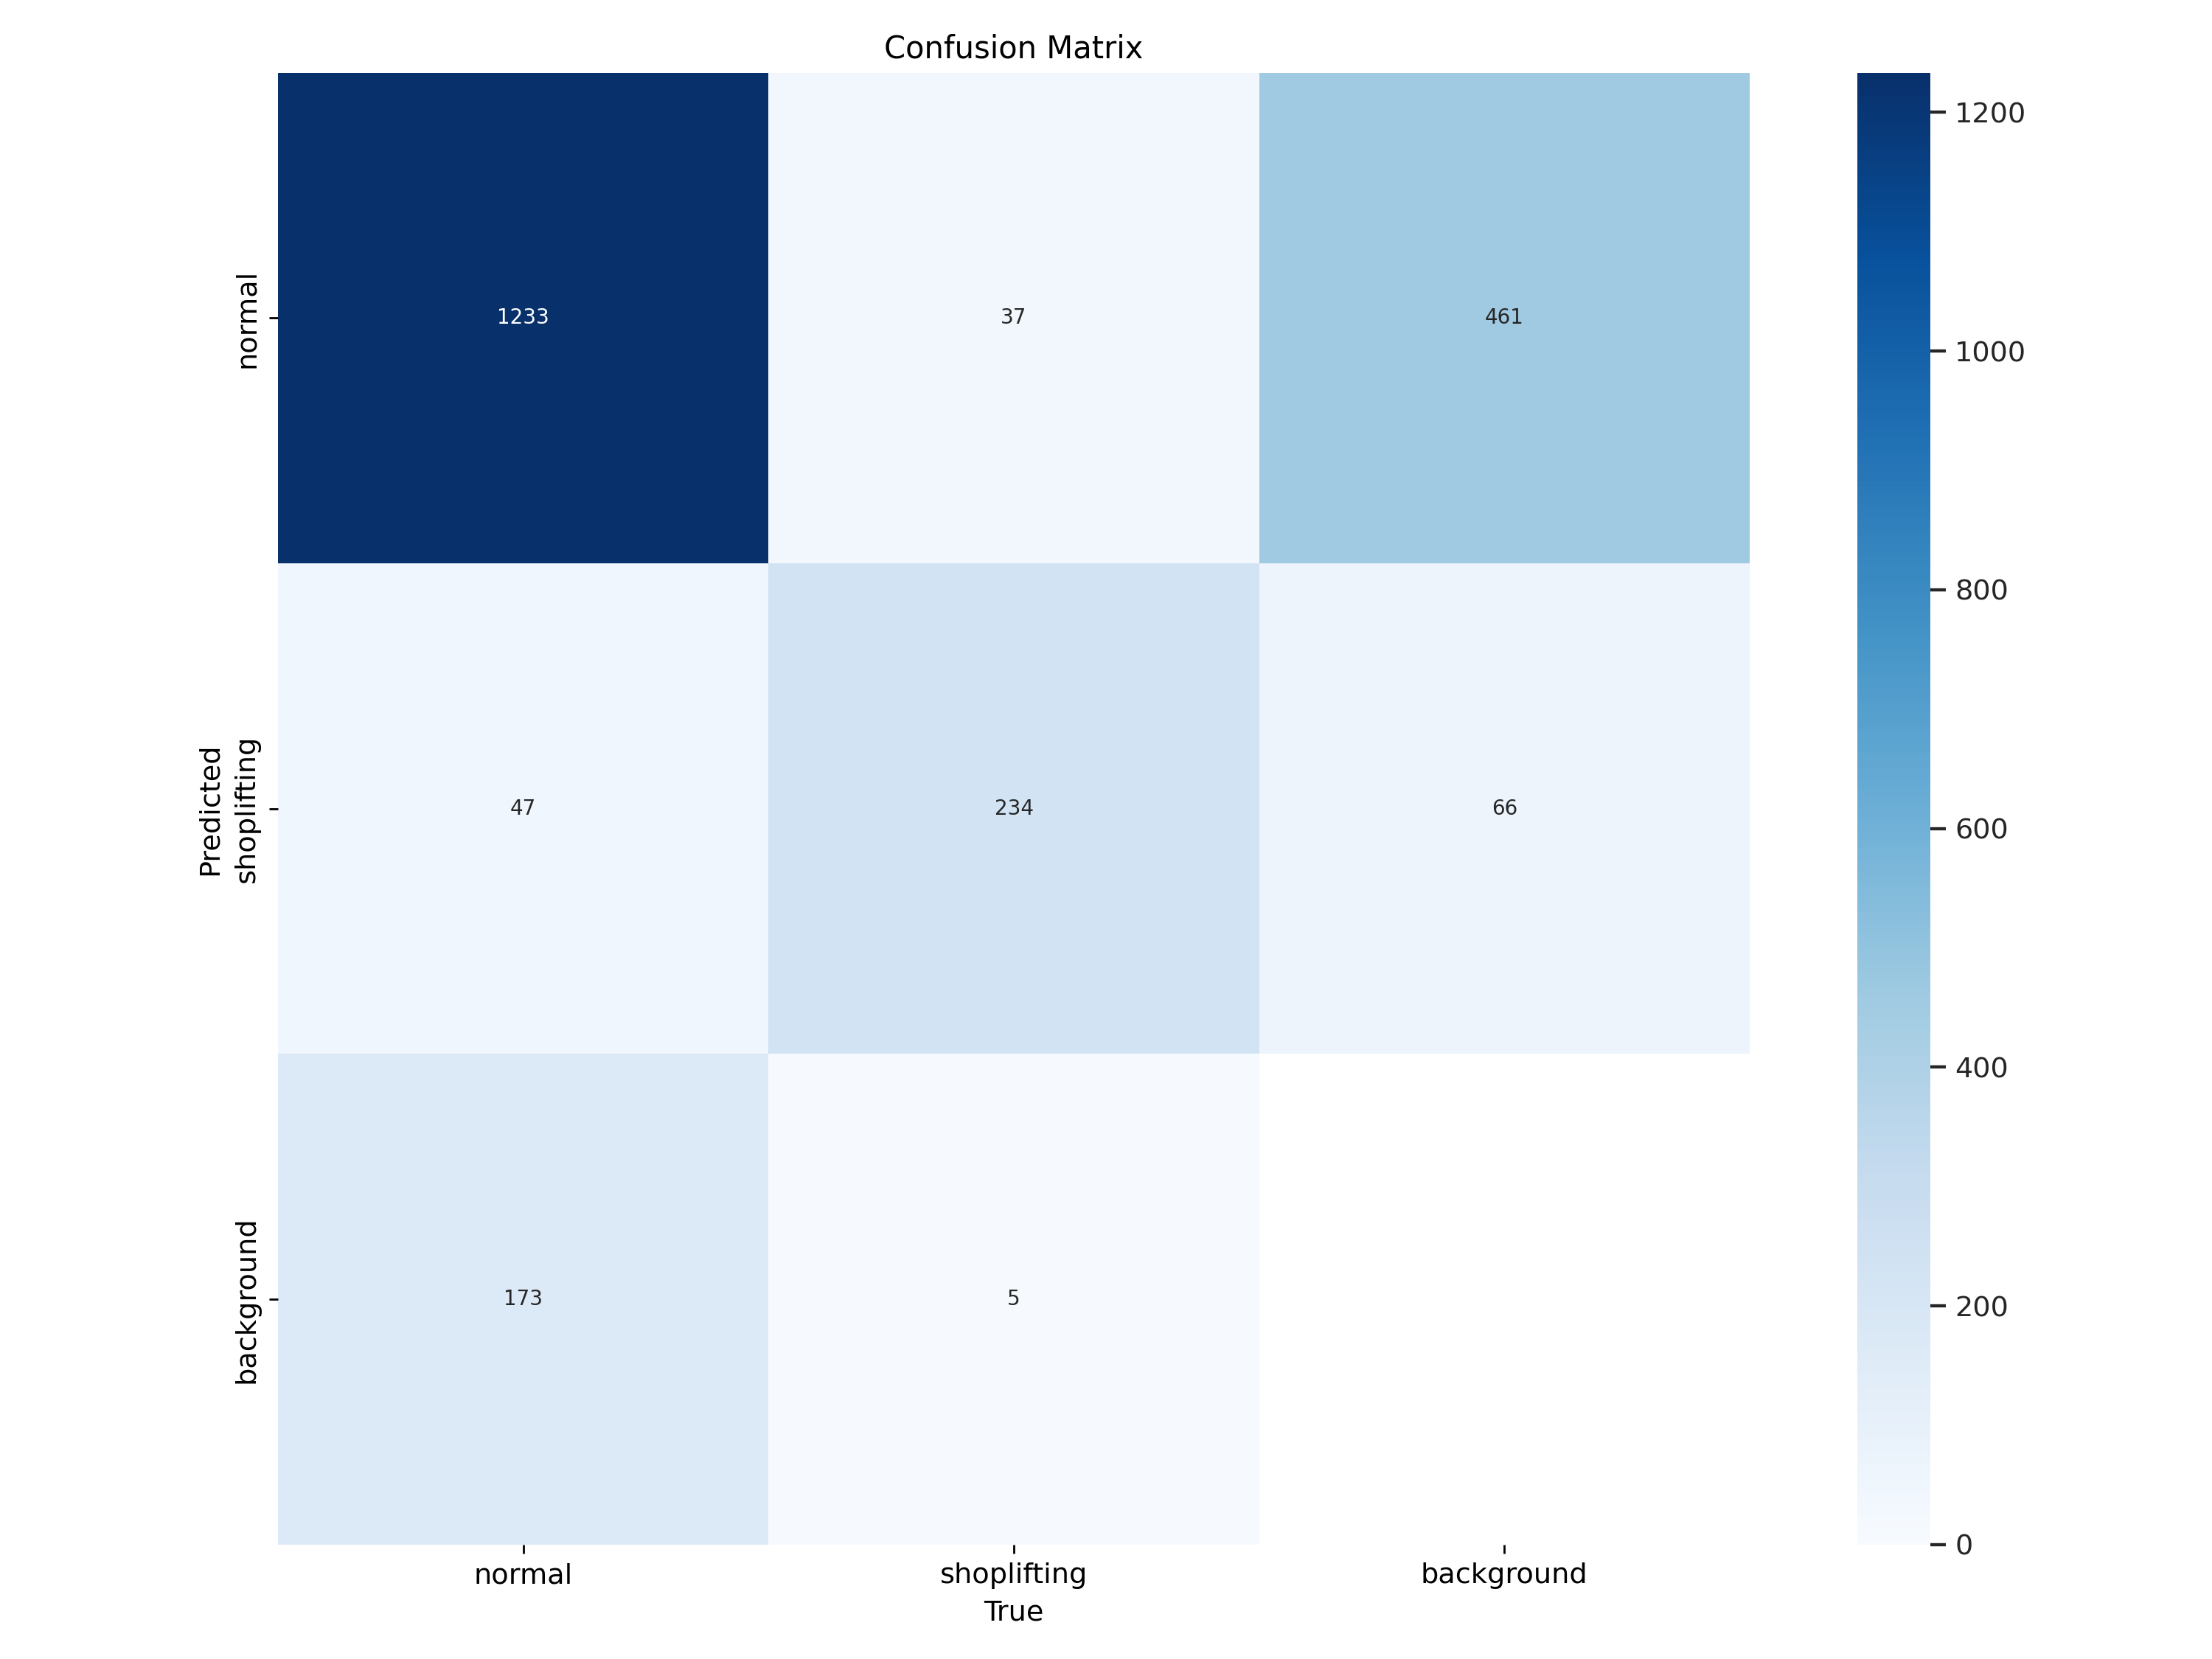

In [14]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=1000)

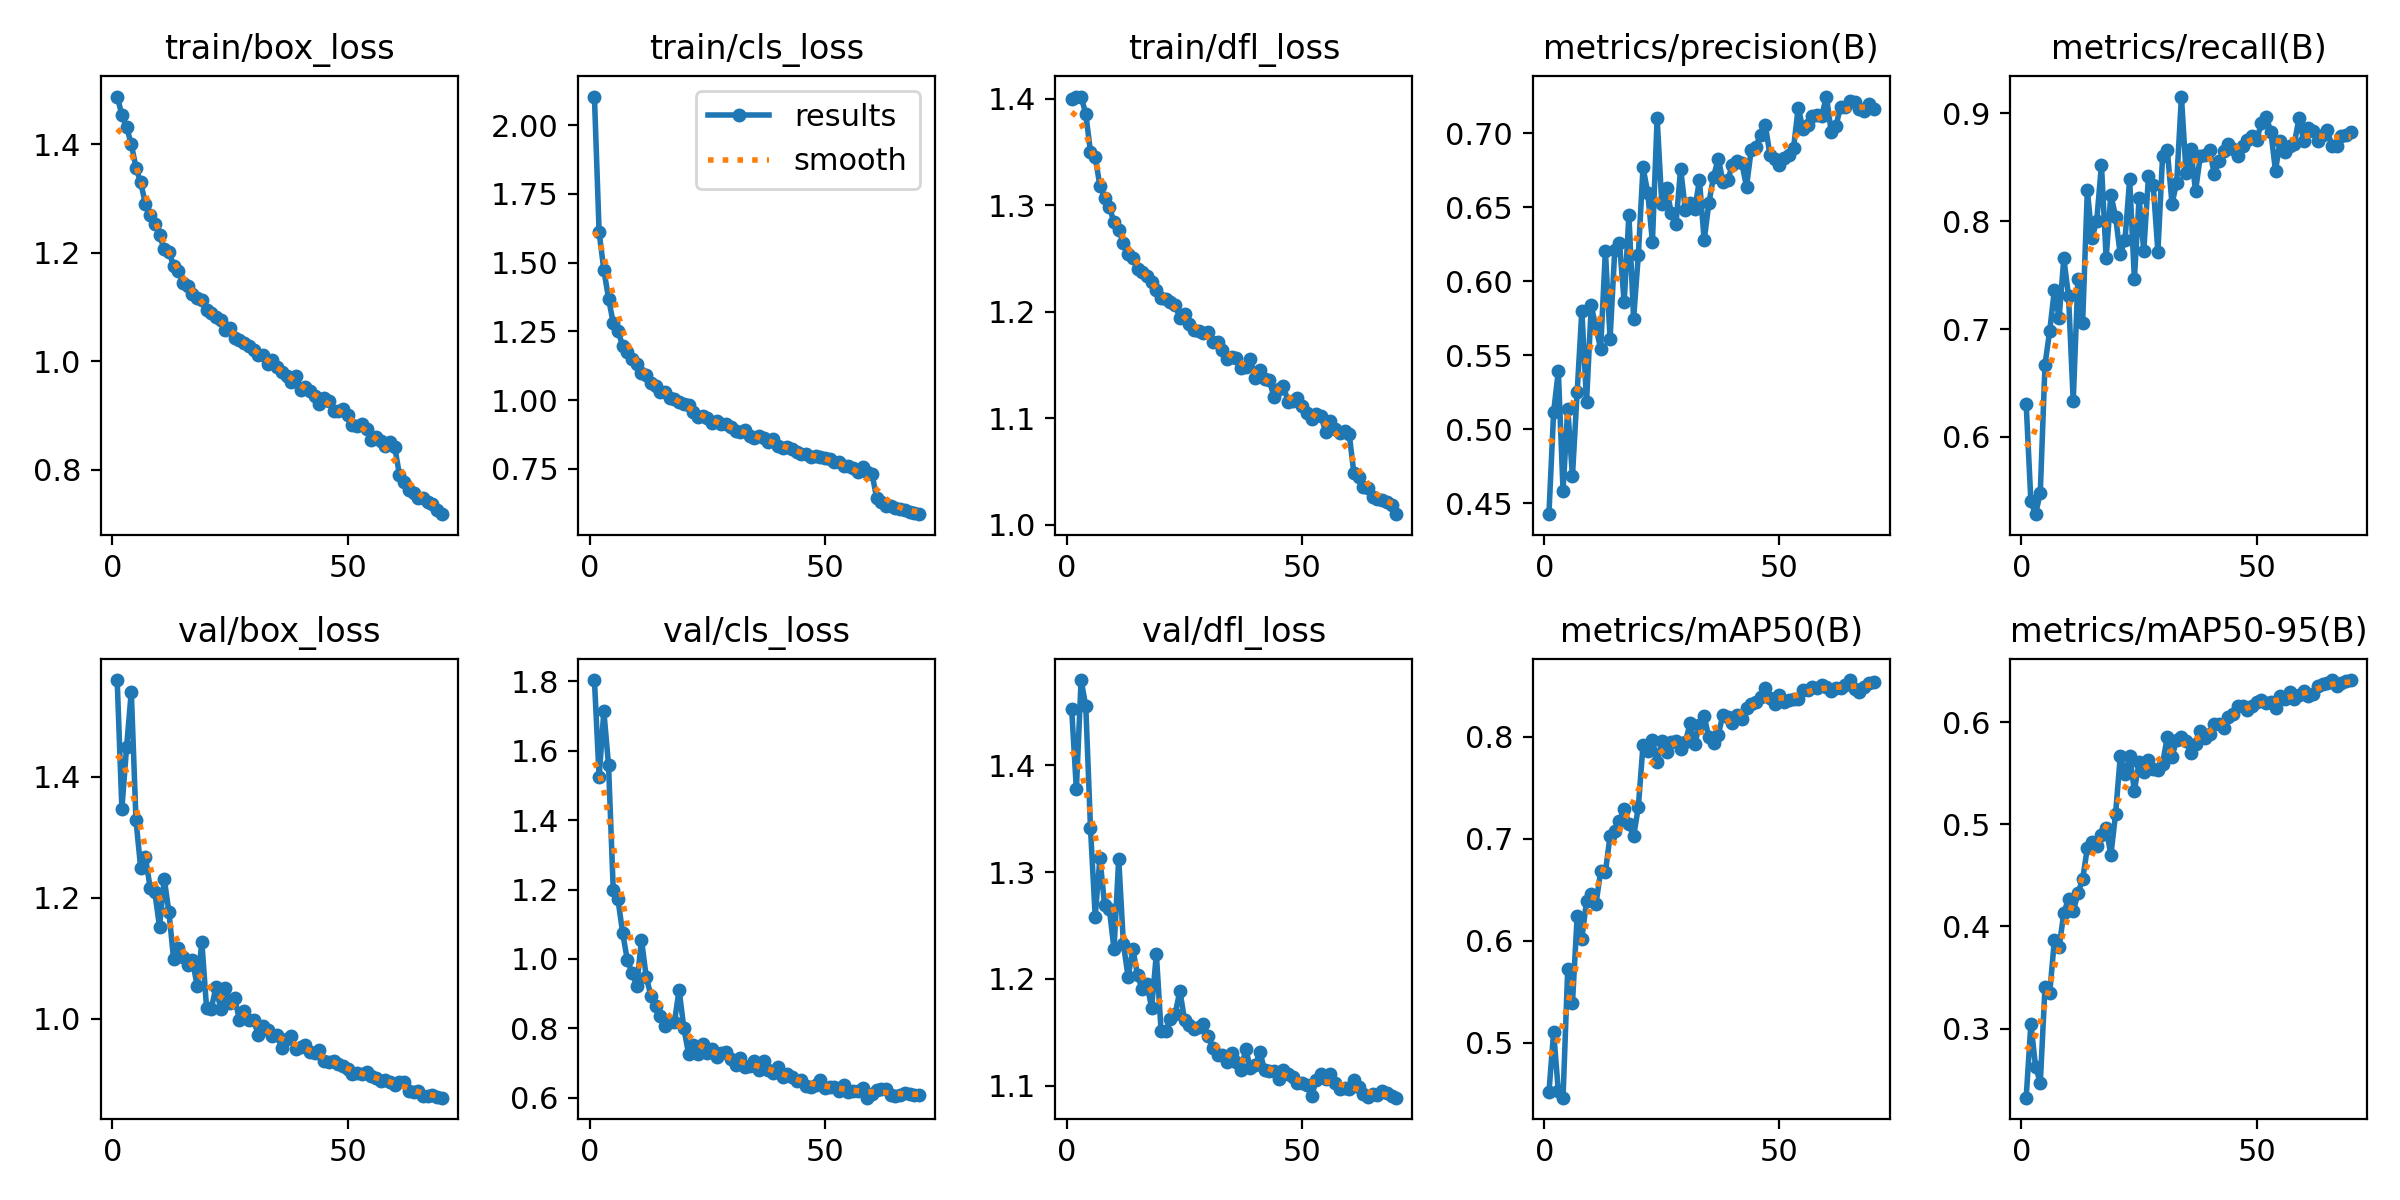

In [15]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=1000)

In [16]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['normal', 'shoplifting']

In [17]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [18]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.2894263805542939
mAP 50 0.4790339250846838
mAP 75 0.29729788289114367


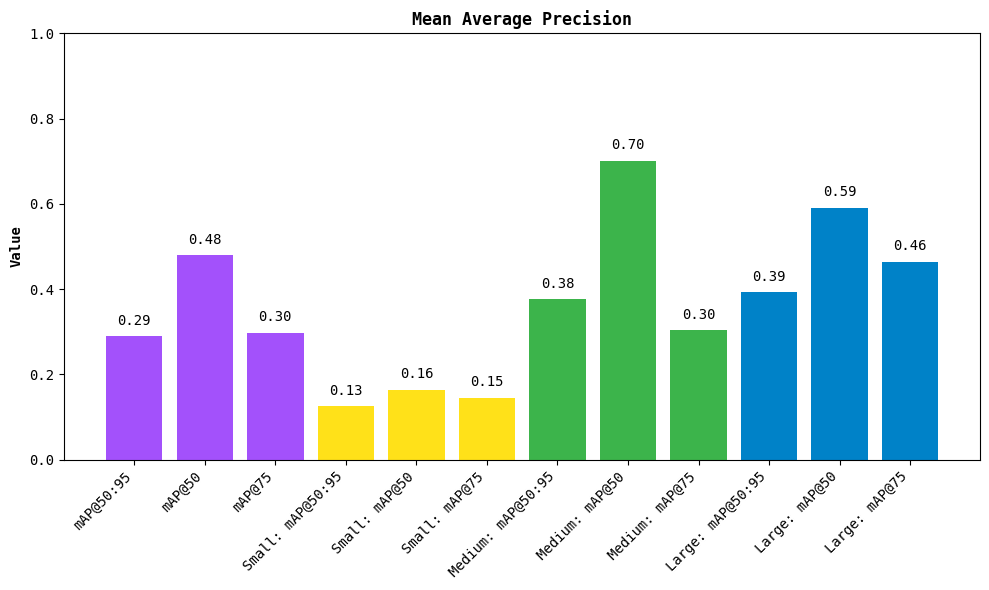

In [19]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [20]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

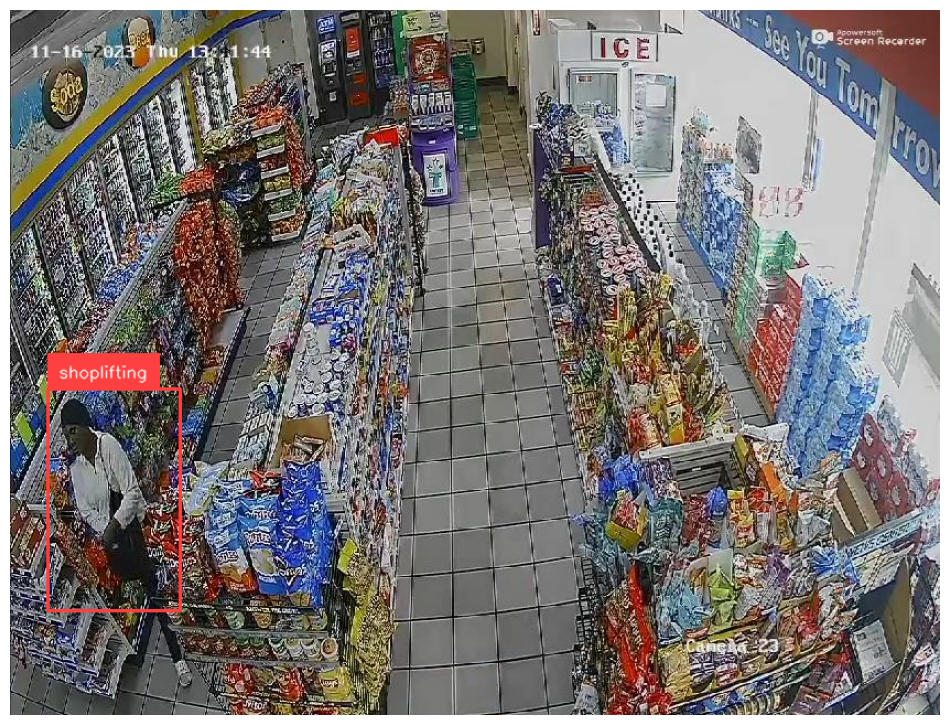

In [22]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)